
# 270. 컴퓨터 비전(Vision)을 위한 전이학습(Transfer Learning)
=======================================================

- 실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에, (무작위 초기화를 통해) 처음부터 합성곱 신경망(Convolutional Network) 전체를 작성하는 경우는 매우 적다.   


- 대신, 매우 큰 데이터셋(예. 100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱 신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업을 위한 초기 설정 또는 고정된 특징 추출기(fixed feature extractor)로 사용

### 전이학습의 2 가지 시나리오:

-  **합성곱 신경망의 미세조정(finetuning)**: 신경망을 ImageNet 등으로 미리 학습한 신경망으로 초기화하고 parameter 미세 조정  


-  **고정된 특징 추출기로써의 합성곱 신경망**: 마지막 완전 연결층을 제외한 모든 신경망의 가중치를 고정. 마지막의 완전 연결층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습.  


### torch 제공 pre-trained models
```
    import torchvision.models as models  
    
    resnet18 = models.resnet18()  
    alexnet = models.alexnet()  
    vgg16 = models.vgg16()  
    squeezenet = models.squeezenet1_0()  
    densenet = models.densenet161()  
    inception = models.inception_v3()  
    googlenet = models.googlenet()  
    shufflenet = models.shufflenet_v2_x1_0()  
    mobilenet = models.mobilenet_v2()  
    resnext50_32x4d = models.resnext50_32x4d()  
    wide_resnet50_2 = models.wide_resnet50_2()  
    mnasnet = models.mnasnet1_0()  
```   

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

데이터 불러오기
---------------

- **개미** 와 **벌** 을 분류하는 이진 분류 모델을 학습
    - 대략 120장 정도의 훈련 이미지와, 75장의 검증용 이미지를 이용
    - 전이학습을 통해 소량의 데이터로도 일반화 가능
    - ImageNet의 일부 data 이용

-  데이터를 [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   에서 다운로드 받아 현재 디렉토리에 압축을 푼다

In [2]:
!wget  https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q "hymenoptera_data.zip"

--2025-02-10 08:46:21--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.83.16, 18.239.83.126, 18.239.83.32, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.83.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   173MB/s    in 0.3s    

2025-02-10 08:46:21 (173 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
# 데이터 증가(augmentation) 및 ResNet 에 적합한 normalization 적용
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 이미지를 무작위 크기 및 비율로 자른 후 224x224로 조정
        transforms.RandomHorizontalFlip(),  # 이미지를 50% 확률로 수평으로 뒤집음
        transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 텐서의 채널별 평균 및 표준편차를 사용하여 정규화
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),  # 이미지의 짧은 측을 256 픽셀로 조정
        transforms.CenterCrop(224),  # 이미지 중앙을 224x224 크기로 자름
        transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 텐서의 채널별 평균 및 표준편차를 사용하여 정규화
    ]),
}


# ImageFolder 라이브러리

- 계층적인 폴더 구조를 가지고 있는 데이터셋을 불러올 때 사용할 수 있다. 각 이미지들이 자신의 레이블(Label) 이름으로 된 폴더 안에 들어가 있는 구조라면, ImageFolder 라이브러리를 이용하여 이를 바로 불러와 객체로 만들면 된다.

ImageFolder를 사용하기 위해선 가장 먼저 수집된 데이터의 폴더구조를 아래와 같이 설계해야한다  

최상위 경로 아래에 각각의 class name을 가지는 폴더를 구성하고 그 하위경로에 이미지가 저장되어있는 방식이다.
```
root_dir
    | --- ants/
    |      |-- 0001.jpg
    |      |-- 0002.jpg
    |      |-- ...
    | --- bees/
    |      |-- 0001.jpg
    |      |-- 0002.jpg
    |      |-- ...
    | --- rabbit/
    |      |--...
```

In [4]:
data_dir = 'hymenoptera_data'
train_dir = os.path.join(data_dir, 'train')
val_dir  = os.path.join(data_dir, 'val')

print(os.listdir(data_dir))
print(os.listdir(train_dir))
print(os.listdir(val_dir))

['val', 'train']
['bees', 'ants']
['bees', 'ants']


### `datasets.ImageFolder(folder, transform)` data loader 생성

In [7]:
# datasets.ImageFolder를 사용하여 훈련 데이터셋을 로드
# 이 함수는 주어진 디렉토리 경로에서 이미지 파일들을 자동으로 찾아서 레이블을 할당
# data_dir은 데이터가 저장된 루트 디렉토리
# 'train' 폴더 안에 있는 이미지들은 훈련을 위해 사용
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])

val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

# DataLoader를 사용하여 훈련 데이터셋에 대한 배치를 준비
# - num_workers=4: 데이터를 로드하는 데 사용할 서브 프로세스 개수 (성능 최적화)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)

# 검증 데이터셋에 대한 DataLoader 설정
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True, num_workers=4)

In [8]:
class_names = train_data.classes
class_names

['ants', 'bees']

In [9]:
print(len(train_data), len(val_data))
print(class_names)

244 153
['ants', 'bees']


### 일부 이미지 시각화하기

- `torchvision.utils.make_grid(tensor)`  
  - `tensor (Tensor 또는 list)`: 4차원 텐서 `(B x C x H x W)` 형태의 미니 배치 텐서 또는 같은 크기의 이미지 리스트입니다. (여기서 B는 이미지 개수, C는 채널 수, H와 W는 이미지의 높이와 너비)  
  - `nrow (int, 선택)`: 한 줄에 표시할 이미지 개수입니다. 최종 그리드는 `(B / nrow, nrow)` 형태가 됩니다. 기본값은 8입니다.

In [10]:
def imshow(inp, title=None):
    # 입력 텐서를 NumPy 배열로 변환하고 차원을 재배열합니다. PyTorch는 이미지를 [C, H, W] 형식으로 처리하지만,
    # matplotlib는 [H, W, C] 형식을 요구하므로, 차원의 순서 변경
    inp = inp.numpy().transpose(1, 2, 0)

    # 이미지를 정규화할 때 사용된 평균과 표준편차를 정의. 이 값들은 모델이 학습될 때 사용된 값들과 일치해야 합니다.
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    # 정규화된 이미지 데이터를 원래의 범위로 되돌립니다.
    inp = inp * std + mean

    # np.clip 함수를 사용하여 이미지 데이터의 값이 0과 1 사이로 제한됩니다. 이는 이미지 데이터를 적절한 범위 내로 조정하기 위함입니다.
    inp = np.clip(inp, 0, 1)

    # 제목이 있을 경우 이미지 위에 제목을 표시합니다.
    if title is not None:
        plt.title(title)

    plt.imshow(inp)

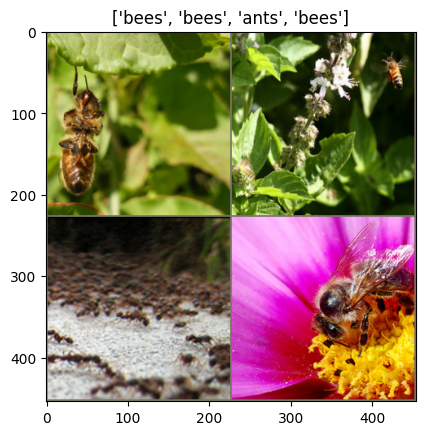

In [11]:
# 훈련 데이터 로더에서 첫 번째 배치를 가져옵니다.
inputs, classes = next(iter(train_loader))

# 가져온 이미지 배치를 그리드 형태로 만듭니다. nrow=2는 한 행에 이미지를 두 개씩 배치하겠다는 의미입니다.
out = torchvision.utils.make_grid(inputs, nrow=2)

# 만들어진 이미지 그리드를 시각화합니다.
# title에는 각 이미지의 클래스 이름을 표시하기 위해 classes 배열에서 각 클래스 인덱스에 해당하는 이름을 조회하여 리스트로 만듭니다.
imshow(out, title=[class_names[x] for x in classes])

Model Train
--------------

##  Fine-Tuning vs Feature Extraction 비교

|  | **Fine-Tuning (방법 1)** | **Feature Extraction (방법 2)** |
|---|-----------------|-------------------|
| **훈련되는 가중치** | 전체 네트워크 | 마지막 FC 레이어만 |
| **학습 속도** | 느림 | 빠름 |
| **필요한 데이터 크기** | 크면 좋음 | 작아도 가능 |
| **오버피팅 위험** | 있음 (데이터 적을 경우) | 적음 |
| **적응력** | 새 데이터셋에 최적화 가능 | 기존 특징을 활용 |  


    1️. 데이터셋이 크고 충분한 경우 → **Fine-Tuning**  
    🔹 학습 시간이 오래 걸리지만, 모델 성능이 더 높아질 가능성이 큼  

    2️. 데이터셋이 작고 제한적인 경우 → **Feature Extraction**  
    🔹 빠르게 학습할 수 있으며, 과적합 가능성이 낮음  


## 방법 1. pre-trained  ResNet 신경망 전체를 미세조정(finetuning)

- 미리 학습된 모델을 불러온 후 마지막의 완전 연결층 만을 새로 작성하고 **전체 parameter** 를 fine tuning

In [12]:
# torchvision의 models 모듈에서 사전 학습된(pretrained) ResNet-18 모델을 로드
model_ft = torchvision.models.resnet18(weights="DEFAULT")

# 모델의 마지막 완전 연결(fully connected, fc) 레이어의 입력 특징(feature) 수를 조회
# 이 값은 ResNet-18 모델의 마지막 레이어에 입력되는 특징 벡터의 차원 수입니다.
num_features = model_ft.fc.in_features

# 조회한 특징 수 출력
print(num_features)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]

512


In [13]:
# fc layer 출력의 크기를 1000 에서 2로 변경
model_ft.fc = nn.Linear(num_features, 2)
model_ft.fc

Linear(in_features=512, out_features=2, bias=True)

In [14]:
# 모델을 현재 사용 중인 디바이스(CPU 또는 GPU)로 이동시킵니다.
model_ft.to(device)

# 손실 함수로 크로스 엔트로피 손실을 사용
criterion = nn.CrossEntropyLoss()

# 모델의 모든 매개변수를 최적화 대상으로 합니다.
# SGD 사용. 학습률(lr)은 0.001, 모멘텀은 0.9로 설정합니다.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 학습률 스케줄러 (성능이 향상되지 않을 때 자동 조정)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode="max", patience=3, factor=0.1)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    s = time.time()  # 훈련 시작 시간

    # 최고의 모델 가중치를 저장하기 위한 변수. 초기값은 현재 모델의 가중치
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # 지금까지의 최고 정확도

    for epoch in range(num_epochs):  # 에폭 수만큼 반복
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # 모델을 훈련 모드로 설정
        train_loss = 0  # 훈련 손실 초기화
        train_acc = 0   # 훈련 정확도 초기화

        for x, y in train_loader:  # 훈련 데이터셋을 배치 단위로 순회
            x, y = x.to(device), y.to(device)  # 데이터를 현재 디바이스로 이동

            optimizer.zero_grad()  # 옵티마이저의 그라디언트 초기화

            z = model(x)  # 모델을 통해 예측값 계산
            preds = z.argmax(1)  # 가장 높은 값을 가진 인덱스를 예측값으로 선택

            loss = criterion(z, y)  # 손실 계산
            loss.backward()  # 손실에 대한 그라디언트 계산
            optimizer.step()  # 모델의 가중치 업데이트

            train_loss += loss.item() * x.size(0)  # 배치 손실 누적
            train_acc += torch.sum(preds == y).item()  # 정확한 예측의 수 누적

        train_acc /= len(train_data)  # 에폭당 평균 훈련 정확도 계산
        train_loss /= len(train_data)  # 에폭당 평균 훈련 손실 계산

        scheduler.step(train_loss)  # 에폭마다 학습률 조정

        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0  # 검증 손실 초기화
        val_acc = 0  # 검증 정확도 초기화

        with torch.inference_mode():  # 그라디언트 계산 비활성화
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                z = model(x)
                preds = z.argmax(1)

                loss = criterion(z, y)

                val_loss += loss.item() * x.size(0)
                val_acc += torch.sum(preds == y).item()

        val_acc /= len(val_data)  # 에폭당 평균 검증 정확도 계산
        val_loss /= len(val_data)  # 에폭당 평균 검증 손실 계산

        print(f'Epoch {epoch+1}/{num_epochs}==> train loss: {train_loss:.4f}, ' +
              f'val loss: {val_loss:.4f}, train acc: {train_acc:.2f}, ' +
              f'val acc: {val_acc:.2f}')

        # 현재 에폭의 모델이 이전 에폭의 모델보다 좋은 경우, 정보를 갱신합니다.
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - s  # 훈련 시간 계산
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=25)

Epoch 0/24
----------
Epoch 1/25==> train loss: 0.5287, val loss: 0.1549, train acc: 0.80, val acc: 0.94
Epoch 1/24
----------
Epoch 2/25==> train loss: 0.3479, val loss: 0.1614, train acc: 0.85, val acc: 0.95
Epoch 2/24
----------
Epoch 3/25==> train loss: 0.5632, val loss: 0.6037, train acc: 0.75, val acc: 0.76
Epoch 3/24
----------
Epoch 4/25==> train loss: 0.5477, val loss: 1.3343, train acc: 0.78, val acc: 0.67
Epoch 4/24
----------
Epoch 5/25==> train loss: 0.5503, val loss: 0.3431, train acc: 0.80, val acc: 0.86
Epoch 5/24
----------
Epoch 6/25==> train loss: 0.6845, val loss: 0.5282, train acc: 0.74, val acc: 0.82
Epoch 6/24
----------
Epoch 7/25==> train loss: 0.3262, val loss: 0.2612, train acc: 0.89, val acc: 0.91
Epoch 7/24
----------
Epoch 8/25==> train loss: 0.5029, val loss: 0.3849, train acc: 0.84, val acc: 0.88
Epoch 8/24
----------
Epoch 9/25==> train loss: 0.4752, val loss: 0.3385, train acc: 0.80, val acc: 0.89
Epoch 9/24
----------
Epoch 10/25==> train loss: 0.3369

In [20]:
predictions = []
labels = []

# 모델의 평가 모드 설정
with torch.inference_mode():
    # 검증 데이터 로더를 통해 배치 단위로 데이터를 가져옴
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        z = model_ft(x)
        preds = z.argmax(1)  # 최대 확률 값을 가진 인덱스를 예측값으로 선택

        # 예측된 인덱스를 리스트에 추가
        predictions.extend(preds.cpu().numpy())
        # 실제 레이블을 리스트에 추가
        labels.extend(y.cpu().numpy())

    # 정답을 맞춘 케이스의 인덱스를 구함
    correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
    # 정답을 틀린 케이스의 인덱스를 구함
    incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도를 계산하여 출력
print(f"accuracy = {len(correct_indices) / len(predictions) * 100:.2f} %")

accuracy = 94.77 %


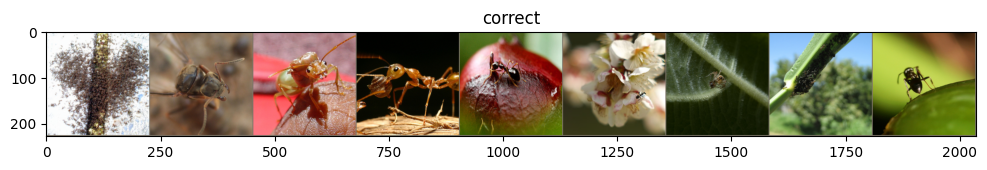

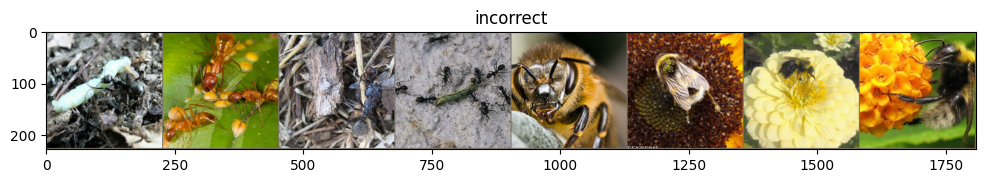

In [21]:
inputs = []
# 정답을 맞춘 데이터의 이미지를 추출하여 inputs 리스트에 추가
for idx in correct_indices[:9]:
    inputs.append(val_data[idx][0])
# 추출한 이미지들을 그리드 형태로 나열
out = torchvision.utils.make_grid(inputs, nrow=9)
# 이미지를 출력하기 위한 그림의 크기를 설정하고, 이미지 출력
plt.figure(figsize=(12, 4))
imshow(out, 'correct')  # 'correct'라는 제목으로 정답을 맞춘 이미지들을 출력

inputs = []
# 정답을 틀린 데이터의 이미지를 추출하여 inputs 리스트에 추가
for idx in incorrect_indices[:9]:
    inputs.append(val_data[idx][0])
# 추출한 이미지들을 그리드 형태로 나열
out = torchvision.utils.make_grid(inputs, nrow=9)
# 이미지를 출력하기 위한 그림의 크기를 설정하고, 이미지를출력
plt.figure(figsize=(12, 4))
imshow(out, 'incorrect')  # 'incorrect'라는 제목으로 정답을 틀린 이미지들을 출력

## 방법 2 : Pre-trained ResNet을 weight 고정된 특징 추출기로 사용

- 미리 학습된 모델을 불러온 후 마지막의 **완전 연결층 만을 새로 작성**하되 마지막 계층을 제외한 **신경망의 모든 부분을 고정** (``requires_grad == False`` 로 설정)하여 ``backward()`` 중에 gradient가 계산되지 않도록 함

In [22]:
# 사전 학습된 ResNet18 모델을 불러옴
model_conv = torchvision.models.resnet18(weights="DEFAULT")

# 모델의 모든 파라미터를 고정하여, 학습 중에 파라미터가 업데이트되지 않도록 함
for param in model_conv.parameters():
    param.requires_grad = False

In [23]:
# 모델의 마지막 Fully Connected(FC) 레이어의 입력 특성 수를 가져옴
num_features = model_conv.fc.in_features

# # 마지막 레이어만 새롭게 학습
# 모델의 마지막 FC 레이어를 새로운 레이어로 교체하여, 출력 클래스 수를 2로 설정
model_conv.fc = nn.Linear(num_features, 2)
model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# 학습률 스케줄러 (성능이 향상되지 않을 때 자동 조정)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode="max", patience=3, factor=0.1)

## Train & Evaluation

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         scheduler, num_epochs=25)

Epoch 0/24
----------
Epoch 1/25==> train loss: 0.6019, val loss: 0.6048, train acc: 0.68, val acc: 0.71
Epoch 1/24
----------
Epoch 2/25==> train loss: 0.6460, val loss: 0.2495, train acc: 0.73, val acc: 0.89
Epoch 2/24
----------
Epoch 3/25==> train loss: 0.4320, val loss: 0.1980, train acc: 0.79, val acc: 0.94
Epoch 3/24
----------
Epoch 4/25==> train loss: 0.4184, val loss: 0.1942, train acc: 0.84, val acc: 0.92
Epoch 4/24
----------
Epoch 5/25==> train loss: 0.4846, val loss: 0.1885, train acc: 0.79, val acc: 0.95
Epoch 5/24
----------
Epoch 6/25==> train loss: 0.3770, val loss: 0.1959, train acc: 0.84, val acc: 0.92
Epoch 6/24
----------
Epoch 7/25==> train loss: 0.5215, val loss: 0.4344, train acc: 0.82, val acc: 0.85
Epoch 7/24
----------
Epoch 8/25==> train loss: 0.4552, val loss: 0.2230, train acc: 0.82, val acc: 0.92
Epoch 8/24
----------
Epoch 9/25==> train loss: 0.4931, val loss: 0.2079, train acc: 0.80, val acc: 0.93
Epoch 9/24
----------
Epoch 10/25==> train loss: 0.4046

In [25]:
predictions = []
labels = []

# 모델을 평가 모드로 설정
with torch.inference_mode():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        z = model_conv(x)
        # 출력값 중 최대값을 가진 인덱스를 예측값으로 선택
        preds = z.argmax(1)

        # 예측값을 predictions 리스트에 추가
        predictions.extend(preds.cpu().numpy())
        # 실제 레이블을 labels 리스트에 추가
        labels.extend(y.cpu().numpy())

    # 예측값과 실제 레이블이 일치하는 인덱스를 찾음
    correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
    # 예측값과 실제 레이블이 불일치하는 인덱스를 찾음
    incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도를 계산하여 출력
print(f"accuracy = {len(correct_indices) / len(predictions) * 100:.2f} %")

accuracy = 95.42 %


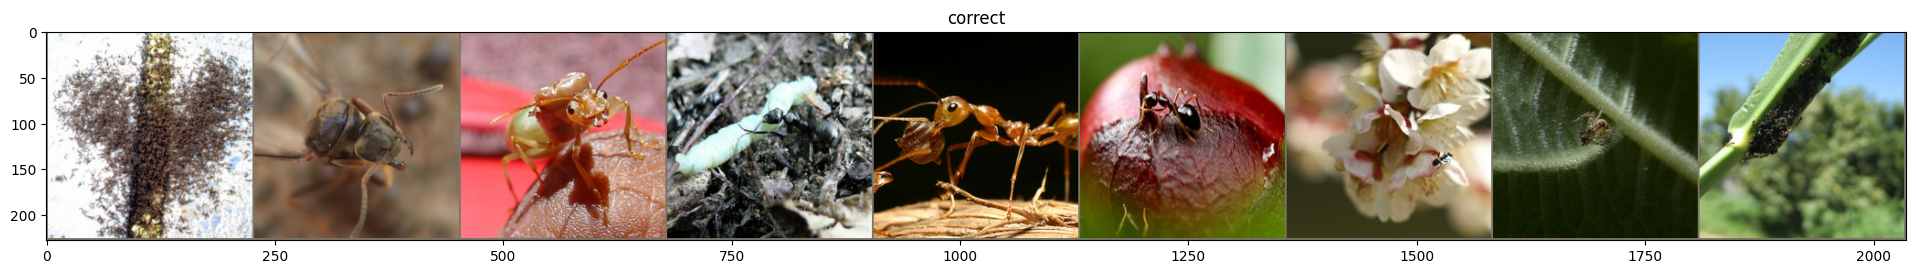

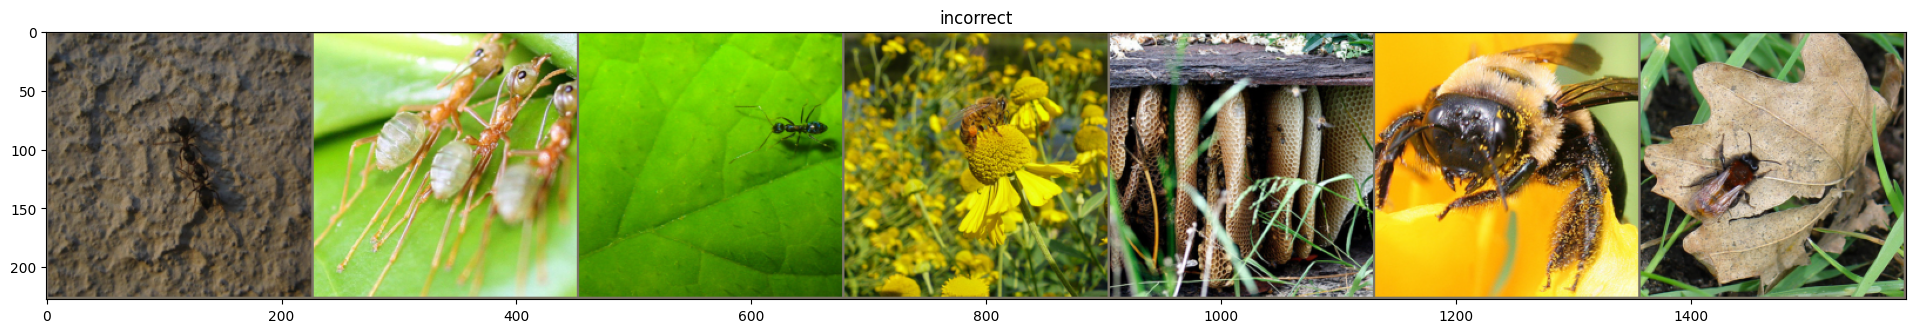

In [26]:
inputs = []
# 정답을 맞춘 데이터의 이미지를 추출하여 inputs 리스트에 추가
for i, idx in enumerate(correct_indices[:9]):
    inputs.append(val_data[idx][0])
# 추출한 이미지들을 그리드 형태로 나열
out = torchvision.utils.make_grid(inputs, nrow=9)

plt.figure(figsize=(24, 8))
imshow(out, 'correct')  # 'correct'라는 제목으로 정답을 맞춘 이미지들을 출력

inputs = []
# 정답을 틀린 데이터의 이미지를 추출하여 inputs 리스트에 추가
for i, idx in enumerate(incorrect_indices[:9]):
    inputs.append(val_data[idx][0])
# 추출한 이미지들을 그리드 형태로 나열
out = torchvision.utils.make_grid(inputs, nrow=9)

plt.figure(figsize=(24, 8))
imshow(out, 'incorrect')  # 'incorrect'라는 제목으로 정답을 틀린 이미지들을 출력